<a href="https://colab.research.google.com/github/mhtattersall/mhtattersall/blob/main/3_Day_Price_%26_Log_Returns_NASDAQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import io

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers

Import stock data to a Pandas dataframe

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['NASDAQ2008.csv']))

Saving NASDAQ2008.csv to NASDAQ2008.csv


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       182 non-null    object 
 1   Open       182 non-null    float64
 2   High       182 non-null    float64
 3   Low        182 non-null    float64
 4   Close      182 non-null    float64
 5   Adj Close  182 non-null    float64
 6   Volume     182 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.1+ KB


Set index in dataframe

In [ ]:
df.set_index("Date", drop=True, inplace=True)

Select Close price column as a dataframe


In [ ]:
df = df[["Close"]]

In [ ]:
type(df[["Close"]])

pandas.core.frame.DataFrame

In [ ]:
df.describe()

,Close
count,182.000000
mean,1597.849888
std,138.401088
min,1268.640015
25%,1506.192504
50%,1588.445007
75%,1711.777465
max,1862.369995


Plot NASDAQ Composite Index price: 7 October 2008 - 26 June 2009

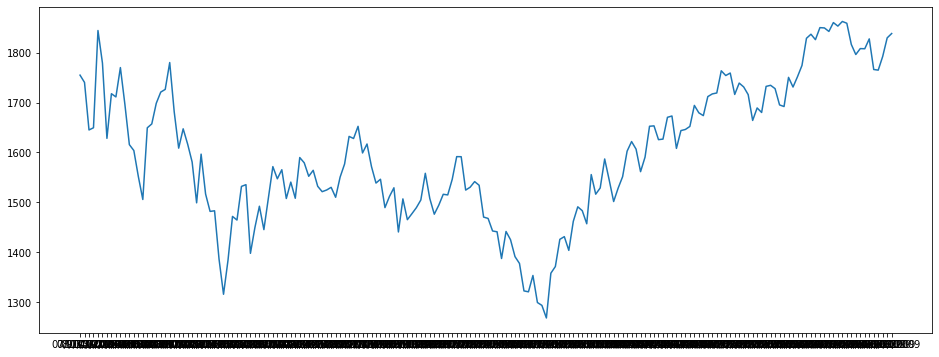

In [ ]:
plt.figure(1, figsize=(16, 6))
_ = plt.plot(df.Close)

Calculate percentage daily returns

In [ ]:
df["Returns"] = df.Close.pct_change()

In [ ]:
df.head(5)

,Close,Returns
Date,,
07/10/2008,1754.880005,NaN
08/10/2008,1740.329956,-0.008291
09/10/2008,1645.119995,-0.054708
10/10/2008,1649.510010,0.002669
13/10/2008,1844.250000,0.118059


Calculate the log daily returns

In [ ]:
df["Log_returns"] = np.log(1 + df["Returns"])

In [ ]:
df.head(5)

,Close,Returns,Log_returns
Date,,,
07/10/2008,1754.880005,NaN,NaN
08/10/2008,1740.329956,-0.008291,-0.008326
09/10/2008,1645.119995,-0.054708,-0.056261
10/10/2008,1649.510010,0.002669,0.002665
13/10/2008,1844.250000,0.118059,0.111594


Plot Log Daily Returns - mean is always centred on zero

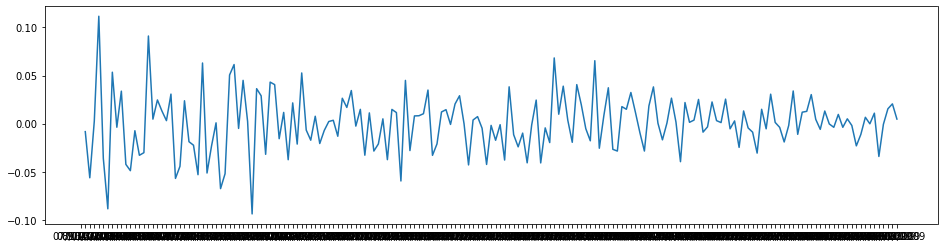

In [ ]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.Log_returns)

Drop null values in the dataframe

In [ ]:
df.dropna(inplace=True)

Select input variables

In [ ]:
X = df[["Close", "Log_returns"]].values

In [ ]:
X

array([[ 1.74032996e+03, -8.32575623e-03],
       [ 1.64512000e+03, -5.62613983e-02],
       [ 1.64951001e+03,  2.66495333e-03],
       [ 1.84425000e+03,  1.11594411e-01],
       [ 1.77901001e+03, -3.60156554e-02],
       [ 1.62832996e+03, -8.85021127e-02],
       [ 1.71770996e+03,  5.34370630e-02],
       [ 1.71129004e+03, -3.74449081e-03],
       [ 1.77003003e+03,  3.37490171e-02],
       [ 1.69668005e+03, -4.23230797e-02],
       [ 1.61575000e+03, -4.88741871e-02],
       [ 1.60391003e+03, -7.35482582e-03],
       [ 1.55203003e+03, -3.28806492e-02],
       [ 1.50590002e+03, -3.01730281e-02],
       [ 1.64946997e+03,  9.10632646e-02],
       [ 1.65720996e+03,  4.68143533e-03],
       [ 1.69852002e+03,  2.46218535e-02],
       [ 1.72094995e+03,  1.31191400e-02],
       [ 1.72632996e+03,  3.12130695e-03],
       [ 1.78012000e+03,  3.06830325e-02],
       [ 1.68164001e+03, -5.69112583e-02],
       [ 1.60869995e+03, -4.43431477e-02],
       [ 1.64740002e+03,  2.37719331e-02],
       [ 1.

Scale data between 0 and 1

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

In [ ]:
X_scaled[:5]

array([[0.79445195, 0.41617229],
       [0.63409293, 0.18279906],
       [0.64148688, 0.46968022],
       [0.96948108, 1.        ],
       [0.8595995 , 0.28136485]])

y is output or target variable

In [ ]:
y = [x[0] for x in X_scaled]

In [ ]:
y[:5]

[0.7944519510367316,
 0.6340929255416747,
 0.6414868843240824,
 0.969481084650635,
 0.859599501780254]

Split data into training data and test data

In [ ]:
split = int(len(X_scaled) * 0.8)
print(split)

144


In [ ]:
X_train = X_scaled[:split]
X_test = X_scaled[split : len(X_scaled)]
y_train = y[:split]

Check X_train and y_train are equal in length

In [ ]:
assert len(X_train) == len(y_train)

Predict the stock price at time t + 1

Using an LSTM model the memory is maintained by setting the time step -  how many steps in the past we want the LSTM to use.

In [ ]:
n = 3 #number of steps
Xtrain = []
ytrain = []
Xtest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i])  # predict next price
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])

In [ ]:
df.head(5)

,Close,Returns,Log_returns
Date,,,
08/10/2008,1740.329956,-0.008291,-0.008326
09/10/2008,1645.119995,-0.054708,-0.056261
10/10/2008,1649.510010,0.002669,0.002665
13/10/2008,1844.250000,0.118059,0.111594
14/10/2008,1779.010010,-0.035375,-0.036016


3 price steps used (Xtrain) to predict next price (ytrain)

In [ ]:
Xtrain[0]

array([[0.79445195, 0.41617229],
       [0.63409293, 0.18279906],
       [0.64148688, 0.46968022]])

In [ ]:
ytrain[0]

0.969481084650635

In [ ]:
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape)]

Demonstrate inverse scaler on 4th price

In [ ]:
scaler.inverse_transform(val)

array([[ 1.8442500e+03, -9.3808937e-02]])

The input for each LSTM layer contains:
- The number of observations
- The time steps
- The features

Add a temporal dimension.

In [ ]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest = (np.array(Xtest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [ ]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)

(141, 3, 2)
(141,)
---
(34, 3, 2)


Keras LSTM model.  Sequential with LSTM, Dropout and Dense layers.

In [ ]:
model = Sequential()
model.add(LSTM(42, return_sequences=True, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(LSTM(42))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))
model.compile(loss="mean_squared_error", optimizer="adam")
model.optimizer.lr = 0.0002 #(lr changed from 0.001)
history = model.fit(
    Xtrain, ytrain, epochs=400, validation_split=0.1, batch_size=16, verbose=1
)

Epoch 1/400
8/8 [==============================] - 5s 136ms/step - loss: 0.2254 - val_loss: 0.4686
Epoch 2/400
8/8 [==============================] - 0s 9ms/step - loss: 0.2100 - val_loss: 0.4296
Epoch 3/400
8/8 [==============================] - 0s 9ms/step - loss: 0.1874 - val_loss: 0.3895
Epoch 4/400
8/8 [==============================] - 0s 11ms/step - loss: 0.1639 - val_loss: 0.3494
Epoch 5/400
8/8 [==============================] - 0s 9ms/step - loss: 0.1428 - val_loss: 0.3085
Epoch 6/400
8/8 [==============================] - 0s 9ms/step - loss: 0.1221 - val_loss: 0.2668
Epoch 7/400
8/8 [==============================] - 0s 11ms/step - loss: 0.1002 - val_loss: 0.2258
Epoch 8/400
8/8 [==============================] - 0s 9ms/step - loss: 0.0817 - val_loss: 0.1852
Epoch 9/400
8/8 [==============================] - 0s 9ms/step - loss: 0.0631 - val_loss: 0.1454
Epoch 10/400
8/8 [==============================] - 0s 10ms/step - loss: 0.0443 - val_loss: 0.1091
Epoch 11/400
8/8 [======

Check learning rate

In [ ]:
print(model.optimizer.lr)

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.0002>


Plot model training loss and validation loss over each epoch

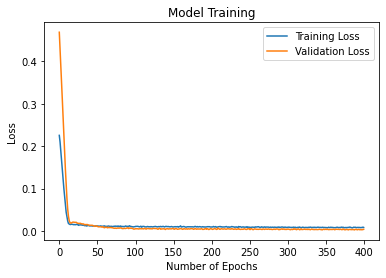

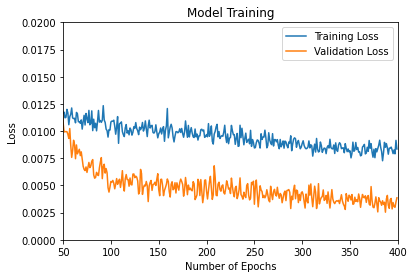

In [ ]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
xc = range(400)
plt.figure()
plt.plot(xc, train_loss, label="Training Loss")
plt.plot(xc, validation_loss, label="Validation Loss")
plt.title("Model Training")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.axis([50,400,0,0.02])
plt.plot(xc, train_loss, label="Training Loss")
plt.plot(xc, validation_loss, label="Validation Loss")
plt.title("Model Training")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 42)             7560      
                                                                 
 lstm_13 (LSTM)              (None, 42)                14280     
                                                                 
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 43        
                                                                 
Total params: 21,883
Trainable params: 21,883
Non-trainable params: 0
_________________________________________________________________


Make predictions on Xtest dataset

In [ ]:
testPredict = model.predict(Xtest)

Concatenate with a zero array so the array has 2 elements to enable to run the inverse scaler

In [ ]:
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

Inverse transfrom predictions from being scaled

In [ ]:
testPredict = scaler.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]

View predictions made for the train dataset and test dataset

In [ ]:
print(testPredict)

[1727.5952370710004, 1718.7409638986196, 1710.2563295054674, 1670.5518870347273, 1678.611746486081, 1668.4516522208548, 1708.5907077933384, 1715.5827022218837, 1718.236138892808, 1694.4424782876695, 1686.7226723575807, 1723.5190538379563, 1717.006581234069, 1737.6141289686705, 1754.1511203314913, 1800.6108751670636, 1816.3797822728825, 1816.901594029678, 1835.631362610171, 1836.4199725246121, 1834.4840137483825, 1847.270295104829, 1842.8937294918812, 1851.7475779954875, 1849.1722449900258, 1817.9188173011148, 1797.2120386295142, 1797.133014848373, 1795.4796377525784, 1812.02168975163, 1768.6831796312738, 1762.858847387569, 1773.7573698737037, 1805.36656382854]


In [ ]:
print(df.Close[148:])

Date
12/05/2009    1715.920044
13/05/2009    1664.189941
14/05/2009    1689.209961
15/05/2009    1680.140015
18/05/2009    1732.359985
19/05/2009    1734.540039
20/05/2009    1727.839966
21/05/2009    1695.250000
22/05/2009    1692.010010
26/05/2009    1750.430054
27/05/2009    1731.079956
28/05/2009    1751.790039
29/05/2009    1774.329956
01/06/2009    1828.680054
02/06/2009    1836.800049
03/06/2009    1825.920044
04/06/2009    1850.020020
05/06/2009    1849.420044
08/06/2009    1842.400024
09/06/2009    1860.130005
10/06/2009    1853.079956
11/06/2009    1862.369995
12/06/2009    1858.800049
15/06/2009    1816.380005
16/06/2009    1796.180054
17/06/2009    1808.060059
18/06/2009    1807.719971
19/06/2009    1827.469971
22/06/2009    1766.189941
23/06/2009    1764.920044
24/06/2009    1792.339966
25/06/2009    1829.540039
26/06/2009    1838.219971
Name: Close, dtype: float64


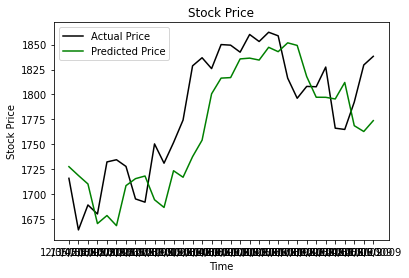

In [ ]:
#plot the test predictions
plt.plot(df.Close[148:], color="black", label=f"Actual Price")
plt.plot(testPredict[:-1], color="green", label="Predicted Price")
plt.title("Stock Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

Calculate mean squared error, mean absolute error and percentage mean absolute error for test

In [ ]:
MSE = mean_squared_error(df.Close[148:], testPredict[:-1])
MAE = mean_absolute_error(df.Close[148:], testPredict[:-1])
average_test_price = np.mean(df.Close[148:])
percentage_MAE = MAD/average_test_price*100
print("Mean Squared Error: %.2f " % (MSE))
print("Mean Absolute Error: %.2f " % (MAE))
print("Percentage Mean Absolute Error: %.2f%% " % (percentage_MAE))

Mean Squared Error: 1768.97 
Mean Absolute Error: 35.88 
Percentage Mean Absolute Error: 2.01% 
